In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
alpha = 0.9
beta = 0.2
gamma = 0.1

Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1-beta]])
            


Z_given_C = np.array([1-alpha, alpha, 0.5])

In [4]:
stats.bernoulli(0.5).rvs(size=[2,2])

array([[0, 0],
       [0, 0]])

In [5]:
xk = np.arange(3)
C_transitition = [
        stats.rv_discrete(values=(xk,Gamma[0,])),
        stats.rv_discrete(values=(xk,Gamma[1,])),
        stats.rv_discrete(values=(xk,Gamma[2,])),
    ]

Z_given_C[C_transitition[2].rvs(size=100)]



array([0.5, 0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.1, 0.9,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.9,
       0.5, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5, 0.5, 0.9, 0.1, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5, 0.5, 0.1, 0.5, 0.5, 0.9,
       0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.9, 0.5, 0.1, 0.5, 0.5, 0.5,
       0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [6]:
def sim(n=1000, T=1000, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0=1, lamb1=5):
    #xk = np.arange(3)   
    Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
    C_transition = [
        stats.rv_discrete(values=(xk,Gamma[0,])),
        stats.rv_discrete(values=(xk,Gamma[1,])),
        stats.rv_discrete(values=(xk,Gamma[2,])),
    ]
    C = np.zeros(T, np.int64)
    C[0] = 2
    for i in range(T-1):
        C[i+1] = C_transition[C[i]].rvs()
    Z_given_C = np.array([1-alpha, alpha, 0.5]) 
    Z = stats.bernoulli(Z_given_C[C]).rvs(size=[n,T])
    X = stats.poisson(np.where(Z, lamb1, lamb0)).rvs()
    return C,Z,X


C, Z, X = sim(10, 100)

<AxesSubplot: >

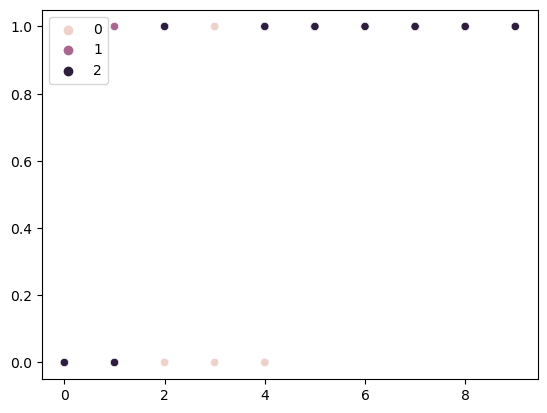

In [7]:
import seaborn as sns
sns.scatterplot(x=X[0],y=Z[0], hue=C)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


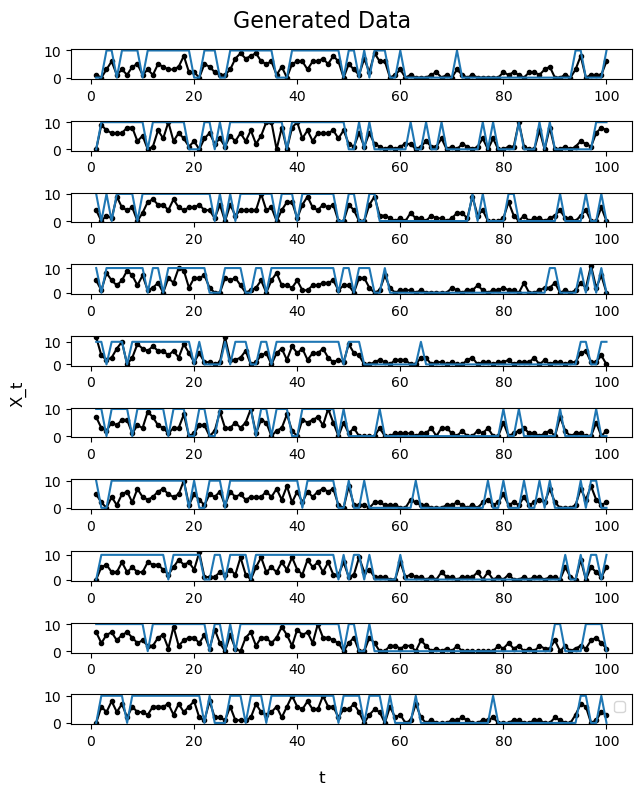

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))
col = ("red", "green", "blue")
color_list = [col[i] for i in C]

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i]*10
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='black')
    axs[i].plot(x_plot, z_plot)#, c=color_list)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.legend()
plt.show()

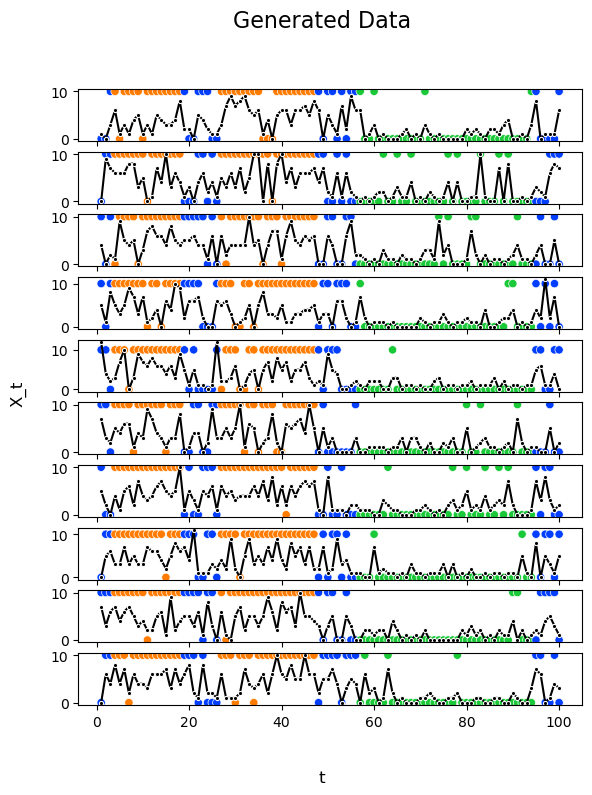

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('bright')


fig, axs = plt.subplots(10, 1, figsize=(6.5, 8))
x_plot = list(range(1, 100+1))
col = ["red", "green", "blue"]
color_list = [col[i] for i in C]

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i] * 10
    sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
    sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs[i], hue=color_list, legend=False)#, label='Z')

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

#plt.tight_layout()
plt.show()


In [28]:
C, Z, X = sim(100, 1000)

lambda0_hat = np.mean(X[Z==0])
lambda1_hat = np.mean(X[Z==1])
alpha_hat   = (np.mean((Z == 0) & (C == 0)) / np.mean(C == 0) + np.mean((Z == 1) & (C == 1)) / np.mean(C == 1))/2
beta_hat    =  np.mean((C == 2) & (np.roll(C,-1) != 2)) / np.mean(C == 2)
gamma_hat   =  np.mean((C != 2) & (np.roll(C,-1) == 2)) / np.mean(C != 2)

print("""
lambda0_hat: {:.3f}, 
lambda1_hat: {:.3f}, 
alpha_hat:   {:.3f}, 
beta_hat:    {:.3f}, 
gamma_hat:   {:.3f}""".format(lambda0_hat, lambda1_hat, alpha_hat, beta_hat, gamma_hat))



lambda0_hat: 1.002, 
lambda1_hat: 5.006, 
alpha_hat:   0.900, 
beta_hat:    0.244, 
gamma_hat:   0.108


EM Algorithm

In [31]:
from scipy.stats import poisson

Z_hat = np.random.choice([0, 1], size=X.shape, p=[0.5,0.5])
C_hat = np.random.choice([0, 1, 2], size=X.shape, p=[0.25,0.25, 0.5])
for i in range(500):
    lambda0_hat = np.mean(X[Z_hat == 0])
    lambda1_hat = np.mean(X[Z_hat == 1])
    Z0_likelihood = np.multiply(poisson(lambda0_hat).pmf(X), np.mean(Z_hat == 0))
    Z1_likelihood = np.multiply(poisson(lambda1_hat).pmf(X), np.mean(Z_hat == 1))
    Z_hat = Z1_likelihood > Z0_likelihood
    # XgivenZ0 = poisson(lambda0_hat).pmf(X)
    # XgivenZ1 = poisson(lambda1_hat).pmf(X)
    # alpha_hat = (np.mean((Z_hat == 0) & (C_hat == 0)) / np.mean(C_hat == 0) + np.mean((Z_hat == 1) & (C_hat == 1)) / np.mean(C_hat == 1))/2
    # C0_likelihood = np.multiply( alpha_hat*XgivenZ0 + (1-alpha_hat)*XgivenZ1, np.mean(C_hat == 0))
    # C1_likelihood = np.multiply( (1-alpha_hat)*XgivenZ0 + alpha_hat*XgivenZ1 , np.mean(C_hat == 1))
    # C2_likelihood = np.multiply( 0.5 * poisson(lambda0_hat).pmf(X) + 0.5 * poisson(lambda0_hat).pmf(X) , np.mean(C_hat == 2))
    # C_hat = np.argmax(np.array([C0_likelihood, C1_likelihood, C2_likelihood]), axis = 0)

print("""
lambda0_hat: {:.3f}, 
lambda1_hat: {:.3f},
alpha_hat""".format(lambda0_hat, lambda1_hat, alpha_hat))



lambda0_hat: 0.903, 
lambda1_hat: 5.309,
alpha_hat


In [12]:
alpha_hat

nan

In [13]:
X.shape

(10, 1000)

Loading experiment 1 through 10


In [14]:
import pandas as pd

In [15]:
Ex1  = pd.read_csv("data/Ex_1.csv")
Ex2  = pd.read_csv("data/Ex_2.csv")
Ex3  = pd.read_csv("data/Ex_3.csv")
Ex4  = pd.read_csv("data/Ex_4.csv")
Ex5  = pd.read_csv("data/Ex_5.csv")
Ex6  = pd.read_csv("data/Ex_6.csv")
Ex7  = pd.read_csv("data/Ex_7.csv")
Ex8  = pd.read_csv("data/Ex_8.csv")
Ex9  = pd.read_csv("data/Ex_9.csv")
Ex10 = pd.read_csv("data/Ex_10.csv")

In [16]:
Ex1

,t,X1,X2,X3,X4,X5,X6,X7,X8
0,1,2,1,1,0,3,4,0,9
1,2,8,6,0,7,4,1,5,6
2,3,3,4,3,7,1,4,7,2
3,4,4,7,0,2,7,7,4,6
4,5,0,6,4,6,2,4,10,8
...,...,...,...,...,...,...,...,...,...
95,96,8,7,5,4,0,6,1,8
96,97,4,2,3,1,6,3,2,3
97,98,6,4,8,4,0,4,0,2
98,99,3,3,5,1,12,4,4,1
